In [1]:
%run ../robustness_analysis.ipynb

In [2]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart:.3f}-{masspole:.3f}-{length:.3f}-{force_mag:.3f}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates
    
    def reset_to(self, state, seed=None):
        self.seed(seed)
        self.state = state
        self.steps_beyond_done = None
        return np.array(self.state, dtype=np.float32)

In [3]:
masscart = [0.1, 2.0]
force_mag = [1.0, 20.0]

# define the range of the deviation parameters
dev_bounds = np.asarray([masscart, force_mag])

# define the range of the initial states
x0_bounds = np.repeat([[-0.05, 0.05]], 4, axis=0)

# define the deviation parameter value for the original environment (no deviation)
delta_0 = np.asarray([
    1.0, # default masscart (not normalized)
    10.0 # default force_mag
])

In [4]:
def env_builder(delta):
    return MutatedCartPoleEnv(masscart=delta[0], force_mag=delta[1]), x0_bounds

In [5]:
# credits to: https://gist.github.com/HenryJia/23db12d61546054aa43f8dc587d9dc2c
class PID:
    def __init__(self):
        self.desired_state = np.array([0, 0, 0, 0])
        self.desired_mask = np.array([0, 0, 1, 0])
        self.P, self.I, self.D = 0.1, 0.01, 0.5
        
        self.reset()
    
    def reset(self):
        self.integral = 0
        self.derivative = 0
        self.prev_error = 0
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def next_action(self, obs):
        error = obs - self.desired_state

        self.integral += error
        self.derivative = error - self.prev_error
        self.prev_error = error

        pid = np.dot(self.P * error + self.I * self.integral + self.D * self.derivative, self.desired_mask)
        action = self.sigmoid(pid)
        return np.round(action).astype(np.int32)

In [6]:
model = PID()

agent = {
    # define the action generation function of the given agent
    'next_action': lambda obs: model.next_action(obs),

    # some agents (like PID) needs to be reset for each run
    'model_reset': lambda : model.reset()
}

In [7]:
obs_space = MutatedCartPoleEnv().observation_space
pos_range = np.asarray([obs_space.low[0], obs_space.high[0]])
angle_range = np.asarray([obs_space.low[2], obs_space.high[2]])

def stl_prop():
    pos = stl.Predicate('pos')
    angle = stl.Predicate('angle')

    pos_threshold = normalize(2.4, pos_range)
    angle_threshold = normalize(12 * 2 * np.pi / 360, angle_range)

    return stl.Always( (pos < pos_threshold) & (angle < angle_threshold) )


def signal_builder(record, time_index):
    return {
        "pos": stl.Signal(
            normalize(np.abs(record[:, 0]), pos_range),
            time_index
        ),
        "angle": stl.Signal(
            normalize(np.abs(record[:, 2]), angle_range),
            time_index
        )
    }

def episode_eval(obs_record, reward_record):
    return compute_stl_rob(stl_prop(), signal_builder, obs_record)

In [8]:
# l-2 norm distance
def dist(delta, delta_0):
    delta = normalize(delta, dev_bounds)
    delta_0 = normalize(delta_0, dev_bounds)
    return np.sqrt(np.sum((delta - delta_0) ** 2))

In [9]:
if not os.path.exists('gifs'):
    os.mkdir('gifs')
if not os.path.exists('data'):
    os.mkdir('data')

In [10]:
analysis = RobustnessAnalysis(env_builder, agent, episode_eval, delta_0, dev_bounds, dist)
analysis.options['falsification_num_trials'] = 1
analysis.options

{'epsilon': 0.01,
 'deviation_num_trials': 3,
 'deviation_sigma': 0.2,
 'deviation_timeout': 10,
 'falsification_sigma': 0.2,
 'falsification_timeout': 1,
 'falsification_num_trials': 1,
 'falsification_episodes': 100,
 'episodes_of_each_x0': 1,
 'steps_of_each_x0': 200}

In [11]:
delta, delta_dist = analysis.any_unsafe_deviation()


================ Any unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=763849, Mon Oct 24 09:29:13 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 1.880084802676952e-01 1.0e+00 2.03e-01  2e-01  2e-01 0:10.6
    2     12 1.551404525806225e-01 1.2e+00 2.06e-01  2e-01  2e-01 0:22.3


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


    3     18 -4.362273911935921e-02 1.3e+00 2.28e-01  2e-01  3e-01 0:33.7
termination on ftarget=0.0 (Mon Oct 24 09:29:48 2022)
final/bestever f-value = -2.078021e-02 -4.362274e-02
incumbent solution: [0.004674169157535728, 0.5519308482290065]
std deviation: [0.2697515213466179, 0.16601467240850842]


In [12]:
print(delta, delta_dist)

[ 0.10047384 11.7418048 ] 0.482228826500683


STL robustness value: -0.04362273911935921
Initial state: [ 0.00545779 -0.0224496  -0.01385373  0.04187898]


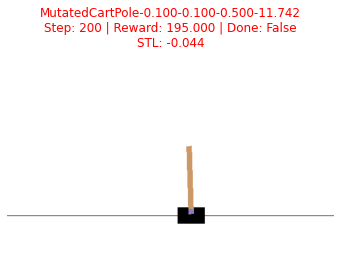

In [13]:
analysis.visualize_deviation(delta, "gifs/any_counterexample.gif")

In [14]:
delta, delta_dist = analysis.min_unsafe_deviation()


================ Min unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=671093, Mon Oct 24 09:30:10 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 3.576808317122732e-02 1.0e+00 1.70e-01  2e-01  2e-01 0:11.9
    2     12 3.576815080745745e-02 1.2e+00 1.28e-01  1e-01  1e-01 0:24.3
    3     18 7.335737100250235e-02 1.4e+00 1.16e-01  8e-02  1e-01 0:37.1
    4     24 2.057600044154487e+01 1.3e+00 1.11e-01  7e-02  9e-02 0:48.9
    5     30 2.776165023201650e+02 1.4e+00 9.93e-02  6e-02  7e-02 1:00.1
    6     36 1.102869305317405e+02 1.3e+00 7.43e-02  4e-02  5e-02 1:10.5
    7     42 5.357831119341866e+00 1.6e+00 5.36e-02  3e-02  3e-02 1:20.6
    8     48 2.184208697135599e+01 1.4e+00 4.89e-02  2e-02  2e-02 1:30.7
    9     54 2.234219834739896e+01 1.2e+00 5.27e-02  2e-02  3e-02 1:40.1
   10     60 1.264614762234337e+01 1.2e+00 5.32e-02  2e-02  2e-02 1:49.8
   12     72 1.316184948220114e+01 1.5e+00 4.

   49    294 5.805787250544113e-01 1.5e+00 1.21e-03  4e-05  5e-05 7:58.7
   52    312 7.246761661910363e-01 1.5e+00 1.29e-03  3e-05  5e-05 8:31.6
   55    330 9.116527223511710e-01 2.5e+00 6.33e-04  1e-05  2e-05 9:04.5
   58    348 1.154207595521894e+00 3.6e+00 9.72e-04  2e-05  4e-05 9:33.0
   61    366 1.468672453500686e+00 5.8e+00 9.71e-04  2e-05  4e-05 10:01.6
termination on timeout=600 (Mon Oct 24 10:00:30 2022)
final/bestever f-value = 1.604821e+00 -1.592826e+00
incumbent solution: [0.4736321495943279, 0.4735645926322811]
std deviation: [2.353752091233996e-05, 4.0809389779517475e-05]
CMAEvolutionStrategyResult(xbest=array([0.00738406, 0.88533131]), fbest=-1.5928263275413643, evals_best=49, evaluations=367, iterations=61, xfavorite=array([0.47363215, 0.47356459]), stds=array([2.35375209e-05, 4.08093898e-05]), stop={'timeout': 600})
{'x': array([0.0204021 , 0.68533794]), 'f': 0.5002619037830831, 'g': [-0.02571023206216927], 'f_al': 0.4857826470136601, 'g_al': [-0.014479256769423004]

In [15]:
print(delta, delta_dist)

[1.60503442 3.91243639] 0.45172827614032074


STL robustness value: -0.250000009934107
Initial state: [-0.0386645  -0.04321717 -0.04942415 -0.01467074]


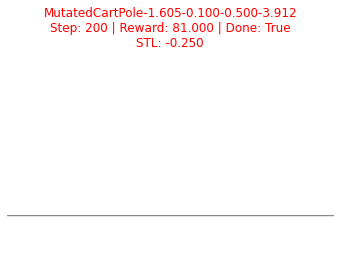

In [16]:
analysis.visualize_deviation(delta, "gifs/min_counterexample.gif")

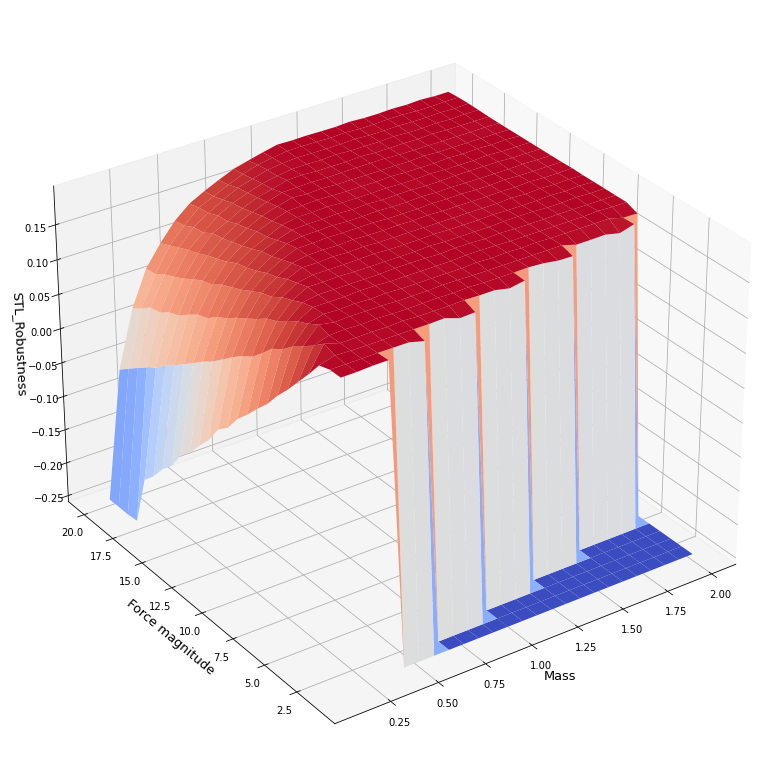

In [17]:
ax, masses, forces, grid_data = analysis.grid_plot(masscart, force_mag, 25, 25, x_name="masses", y_name="forces",
                                                   z_name="STL_Robustness")
ax.set_xlabel('Mass', fontsize=13)
ax.set_ylabel('Force magnitude', fontsize=13)
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape.png')
plt.show()

In [18]:
analysis.robustness_boundary()


================ Min unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=628118, Mon Oct 24 10:15:47 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 2.436660458663938e-02 1.0e+00 2.26e-01  2e-01  3e-01 0:09.6
    2     12 2.915503838757364e-02 1.4e+00 2.00e-01  2e-01  2e-01 0:18.8
    3     18 1.678244667730294e-03 1.4e+00 2.76e-01  3e-01  3e-01 0:28.3
    4     24 2.766799966076941e-02 1.2e+00 2.39e-01  2e-01  3e-01 0:37.7
    5     30 2.787711549491453e-01 1.5e+00 2.24e-01  2e-01  3e-01 0:47.0
    6     36 4.620646436484245e-01 1.6e+00 2.22e-01  2e-01  2e-01 0:56.0
    7     42 4.411690270159609e-01 1.3e+00 1.68e-01  1e-01  2e-01 1:05.0
    8     48 4.301609602337301e-01 1.4e+00 1.46e-01  9e-02  1e-01 1:14.6
    9     54 4.467734210069313e-01 1.4e+00 1.13e-01  7e-02  9e-02 1:24.2
   10     60 4.107835380851345e-01 1.5e+00 8.66e-02  4e-02  6e-02 1:33.2
   11     66 4.536553506510334e-01 1.5e+00 8.

   49    294 4.682844990253505e-01 2.8e+00 1.14e-01  8e-03  1e-02 6:52.1
   52    312 4.675407758490707e-01 3.2e+00 1.53e-01  8e-03  2e-02 7:18.7
   55    330 4.676044589559769e-01 5.3e+00 1.19e-01  7e-03  2e-02 7:47.0
   58    348 4.680565813076151e-01 3.4e+00 1.06e-01  5e-03  8e-03 8:17.0
   61    366 4.674243114039999e-01 2.4e+00 1.14e-01  5e-03  7e-03 8:47.0
   64    384 4.672315409545540e-01 2.3e+00 1.48e-01  6e-03  1e-02 9:18.1
   68    408 4.683236895710254e-01 3.2e+00 1.24e-01  4e-03  9e-03 9:56.7
   69    414 4.678638518755940e-01 3.4e+00 1.01e-01  3e-03  6e-03 10:05.8
termination on timeout=600 (Mon Oct 24 10:46:04 2022)
final/bestever f-value = 4.677186e-01 -3.987549e-01
incumbent solution: [0.009290537310999913, 0.5238028264633009]
std deviation: [0.00300067168629547, 0.006226788850042644]
CMAEvolutionStrategyResult(xbest=array([1.03149308e-04, 9.13585851e-01]), fbest=-0.39875487221378847, evals_best=55, evaluations=415, iterations=69, xfavorite=array([0.00929054, 0.5238028

   13     78 -7.728502805034503e-02 1.3e+00 1.78e-01  9e-02  1e-01 2:07.5
   15     90 -8.673446377964020e-02 1.1e+00 9.56e-02  4e-02  4e-02 2:27.7
   17    102 -6.051212122045749e-02 1.3e+00 6.48e-02  2e-02  2e-02 2:47.8
   19    114 -3.761021096910482e-02 1.2e+00 6.72e-02  2e-02  2e-02 3:07.0
   21    126 -1.738601800584548e-03 1.3e+00 5.75e-02  1e-02  2e-02 3:27.2
   23    138 -7.243834014648671e-03 2.3e+00 4.66e-02  9e-03  1e-02 3:47.4
   25    150 -7.471399913512941e-03 2.5e+00 2.62e-02  4e-03  5e-03 4:07.5
   27    162 -5.284919108456469e-03 1.8e+00 1.89e-02  3e-03  3e-03 4:28.1
   29    174 -3.833447836306392e-03 1.2e+00 1.40e-02  1e-03  2e-03 4:49.1
   31    186 -1.886930453794269e-03 1.3e+00 1.13e-02  9e-04  1e-03 5:10.0
   34    204 2.824025764411272e-03 1.4e+00 7.94e-03  6e-04  6e-04 5:38.2
   37    222 9.494939323006305e-03 1.6e+00 5.01e-03  3e-04  3e-04 6:06.6
   40    240 1.734361740285714e-02 1.5e+00 3.57e-03  2e-04  2e-04 6:33.5
   43    258 2.816503396694970e-02 1.6e+0

    1      6 1.446772756083299e-02 1.0e+00 2.68e-01  3e-01  3e-01 0:08.3
    2     12 3.607270864352195e-02 1.6e+00 2.15e-01  2e-01  3e-01 0:15.7
    3     18 4.701823132890769e-02 1.5e+00 1.84e-01  2e-01  2e-01 0:23.8
    4     24 1.149757296325074e-01 1.3e+00 1.41e-01  1e-01  1e-01 0:32.2
    5     30 1.282102850714167e-01 1.4e+00 1.34e-01  1e-01  1e-01 0:40.5
    6     36 1.018511875684339e-01 1.1e+00 1.06e-01  7e-02  8e-02 0:48.8
    7     42 4.108908905148782e-02 1.2e+00 1.12e-01  6e-02  9e-02 0:57.1
    8     48 3.349234488459464e-02 1.5e+00 9.39e-02  5e-02  6e-02 1:05.3
    9     54 3.328691181451239e-02 1.4e+00 8.13e-02  4e-02  5e-02 1:13.7
   11     66 4.633380926417785e-02 1.4e+00 5.71e-02  3e-02  3e-02 1:30.3
   13     78 8.347739699438322e-02 1.6e+00 4.26e-02  2e-02  2e-02 1:46.7
   15     90 1.178237101877824e-01 1.4e+00 3.08e-02  9e-03  9e-03 2:03.4
   17    102 1.639339400591680e-01 1.2e+00 3.47e-02  9e-03  1e-02 2:19.9
   19    114 2.037252481600935e-01 1.2e+00 2.16e-02

   69    414 1.307973908786133e-03 1.6e+00 1.55e-03  3e-05  4e-05 9:27.4
   73    438 1.334370296785126e-03 2.0e+00 1.01e-03  1e-05  2e-05 10:00.2
termination on timeout=600 (Mon Oct 24 12:05:45 2022)
final/bestever f-value = 1.389168e-03 1.262910e-03
incumbent solution: [0.011720435494308814, 0.5258660645000302]
std deviation: [1.4716496870466593e-05, 1.957711803294937e-05]
CMAEvolutionStrategyResult(xbest=array([0.01216865, 0.52752222]), fbest=0.0012629101077571104, evals_best=291, evaluations=439, iterations=73, xfavorite=array([0.01172044, 0.52586606]), stds=array([1.47164969e-05, 1.95771180e-05]), stop={'timeout': 600})

================ Min unsafe deviation trial 3 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=722779, Mon Oct 24 12:05:45 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 1.725438617531544e-02 1.0e+00 2.17e-01  2e-01  3e-01 0:08.2
    2     12 5.788651790002711e-03 1.3e+00 2.44e-01  3e-01  3e-01 0:1

   41    246 6.231491015988332e-03 7.5e+00 4.33e-03  3e-04  6e-04 5:35.5
   44    264 6.242740564737603e-03 5.5e+00 3.77e-03  2e-04  4e-04 6:00.1
   47    282 6.204742781034169e-03 3.9e+00 4.75e-03  2e-04  5e-04 6:24.9
   50    300 6.240373531626472e-03 4.5e+00 1.04e-02  5e-04  9e-04 6:49.7
   54    324 6.283569152674457e-03 4.1e+00 9.21e-03  4e-04  7e-04 7:22.7
   58    348 6.239406207149883e-03 4.2e+00 6.39e-03  1e-04  4e-04 7:55.5
   62    372 6.313784407557994e-03 5.3e+00 3.08e-03  5e-05  1e-04 8:28.5
   66    396 6.300514841007983e-03 4.1e+00 3.29e-03  6e-05  1e-04 9:01.2
   70    420 6.181661485280037e-03 7.4e+00 4.88e-03  1e-04  2e-04 9:34.2
   74    444 6.295839716385933e-03 7.7e+00 6.16e-03  2e-04  3e-04 10:07.4
termination on timeout=600 (Mon Oct 24 12:33:44 2022)
final/bestever f-value = 6.389782e-03 4.118628e-03
incumbent solution: [0.021794555753995554, 0.5359284299995878]
std deviation: [0.00019054886229893909, 0.00027033181010011347]
CMAEvolutionStrategyResult(xbest=arra

   10     60 1.228558349180292e-02 1.2e+00 1.02e-01  5e-02  6e-02 1:19.4
   12     72 1.109226961307456e-02 1.7e+00 7.63e-02  3e-02  4e-02 1:35.4
   14     84 1.068853234934464e-02 1.5e+00 6.52e-02  2e-02  3e-02 1:51.3
   16     96 1.073330158478209e-02 1.4e+00 3.68e-02  1e-02  1e-02 2:07.2
   18    108 1.047550944876489e-02 1.9e+00 2.40e-02  6e-03  6e-03 2:23.0
   20    120 1.079489188148609e-02 2.2e+00 1.69e-02  3e-03  4e-03 2:38.8
   22    132 1.058934913442831e-02 2.4e+00 1.27e-02  2e-03  3e-03 2:54.6
   24    144 1.054823221637769e-02 2.1e+00 1.06e-02  1e-03  2e-03 3:10.6
   26    156 1.053898054794435e-02 2.9e+00 8.54e-03  1e-03  2e-03 3:26.6
   29    174 1.059788062898332e-02 3.2e+00 7.59e-03  7e-04  1e-03 3:50.8
   32    192 1.072555102623721e-02 4.6e+00 4.94e-03  3e-04  8e-04 4:14.7
   35    210 1.047837819811777e-02 4.8e+00 1.14e-02  8e-04  2e-03 4:38.7
   38    228 1.041603935354401e-02 4.0e+00 7.21e-03  4e-04  8e-04 5:02.6
   41    246 1.066176404820023e-02 8.0e+00 7.83e-03

0.35687070335266496

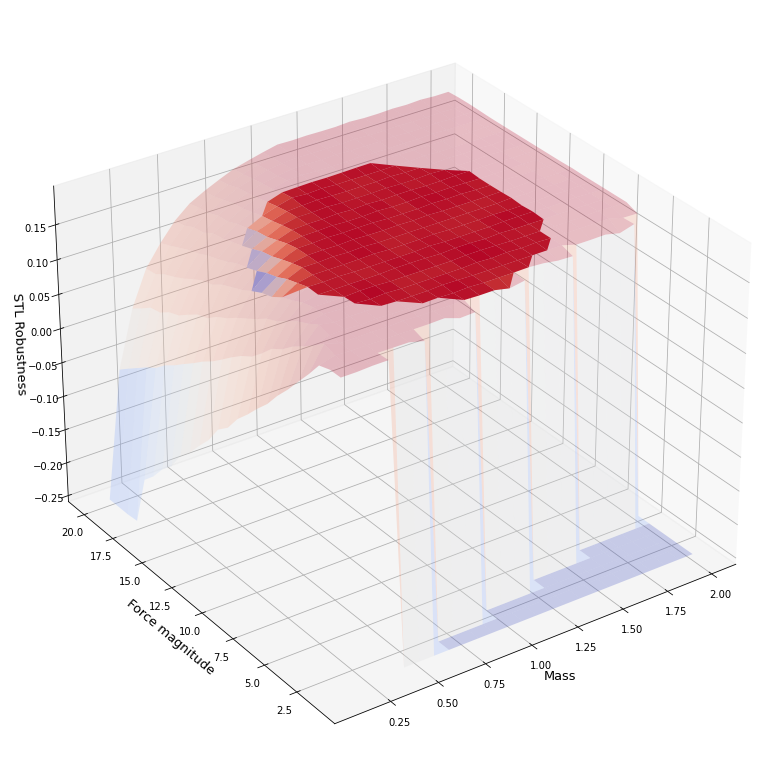

In [12]:
boundary = 0.356871
ax, masses, forces, grid_data = analysis.grid_plot(masscart, force_mag, 25, 25, x_name="masses", y_name="forces",
                                                   z_name='STL Robustness', boundary=boundary)

# center = normalize(delta_0, dev_bounds)
# X = np.linspace(center[0] - boundary, center[0] + boundary)
# Y1 = center[1] + np.sqrt(np.clip(boundary**2 - (X - center[0])**2, 0, None))
# Y2 = center[1] - np.sqrt(np.clip(boundary**2 - (X - center[0])**2, 0, None))
# ax.plot(scale(X, dev_bounds[0]), scale(Y1, dev_bounds[1]), 0.08, zorder=10, color='black')
# ax.plot(scale(X, dev_bounds[0]), scale(Y2, dev_bounds[1]), 0.08, zorder=10, color='black')


ax.set_xlabel('Mass', fontsize=13)
ax.set_ylabel('Force magnitude', fontsize=13)
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape-boundary.png')
plt.show()

In [19]:
def episode_eval_reward(obs_record, reward_record):
    return reward_record.sum() - 200

In [20]:
analysis_reward = RobustnessAnalysis(env_builder, agent, episode_eval_reward, delta_0, dev_bounds, dist)
analysis_reward.options['falsification_num_trials'] = 1

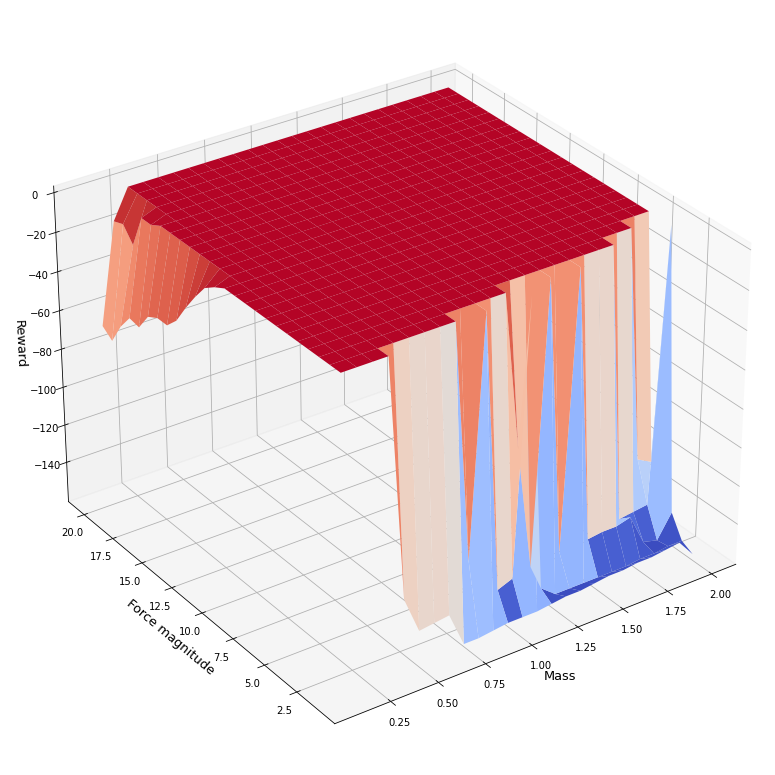

In [21]:
ax, masses, forces, grid_data = analysis_reward.grid_plot(masscart, force_mag, 25, 25, out_dir='data_reward',
                                                          x_name="masses", y_name="forces", z_name='Reward')
ax.set_xlabel('Mass', fontsize=13)
ax.set_ylabel('Force magnitude', fontsize=13)
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape-reward.png')
plt.show()